In [19]:
import torch
import transformers

print("Torch version:{}".format(torch.__version__)) # Torch version:1.12.1
print("Cuda version: {}".format(torch.version.cuda)) # Cuda version: 11.3
print("transformers version: {}".format(transformers.__version__)) # transformers 4.28.0
print("GPU 사용 가능여부: {}".format(torch.cuda.is_available()))

Torch version:1.12.1
Cuda version: 11.3
transformers version: 4.28.0
GPU 사용 가능여부: True


In [20]:
data_path = './KoChatGPT/data_kochatgpt'

## 1. BaseModel and Dataset for RLHF

In [21]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import numpy

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "skt/kogpt2-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [22]:
tokenizer.max_model_input_sizes

{'gpt2': 1024,
 'gpt2-medium': 1024,
 'gpt2-large': 1024,
 'gpt2-xl': 1024,
 'distilgpt2': 1024}

### 1-1. Dataset 확인

#### 1-1-1. SFT 데이터셋

In [23]:
import json
# token 수 이상치 제거할것
data_path_1_SFT = './KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl'
with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

12000


[{'prompt': '불고기용 고기 한우에요?',
  'completion': "'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다.",
  'tokens': 193},
 {'prompt': '쓰던 앱이 유료로 전환됐어',
  'completion': "'어떤 앱인지 모르기 때문에 정확한 답변을 드리기 어렵습니다. 하지만, 일반적으로 유료 전환된 앱은 기존 무료 앱에서 추가적인 기능이나 서비스를 제공하는 경우가 많습니다. 이 경우, 유료 전환 이전 가격이 매우 저렴하거나 무료인 경우가 많으므로, 앱을 계속 사용하려면 추가적인 비용을 지불해야 할 수 있습니다. 하지만, 유료 전환 이후에는 기존 사용자 또는 새로운 사용자 모두가 추가 기능과 높은 품질의 서비스를 이용할 수 있게 됩니다. 따라서, 앱 개발자는 유료 모델로 전환함으로써 앱의 수익을 증가시키고 더 나은 서비스를 제공할 수 있습니다.",
  'tokens': 288},
 {'prompt': '여친이랑 다툼',
  'completion': "'저는 인공지능이기 때문에 여친과의 다툼에 대해서는 조언을 드릴 수는 없습니다. 하지만 다투게 되면 상대방의 말을 경청하는 태도와 서로의 감정을 존중하는 것이 중요합니다. 논리적이고 차분한 대화를 통해 문제를 해결해보세요. 그리고 서로를 이해하고 서로의 의견을 수용하는 것이 중요합니다.",
  'tokens': 153}]

In [ ]:
sum_token, cnt = 0, 0

for data in list_data_dict:
    sum_token += data['tokens']
    cnt += 1

mean_tokens = sum_token/cnt

std_token = 0
for data in list_data_dict:
    std_token += (data['tokens'] - mean_tokens)**2

std_token /= (cnt-1)

print(mean_token, std_token)

#### 1-1-2. RM 데이터셋

In [24]:
data_path_2_RM = './KoChatGPT/data_kochatgpt/kochatgpt_2_RM.jsonl'
with open(data_path_2_RM, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

10220


[{'prompt': '번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나?',
  'completion_0': 'Allow me to answer your question. I know that you are curious about me.',
  'completion_1': '번디는 다양한 인터뷰자들과 뉴스홍보 담당자들과의 면담 때 밝혔다.',
  'completion_2': '라이언에게 말했다.',
  'ranking': [2, 1, 0]},
 {'prompt': '개포주공아파트는 몇 단지로 이루어져 있나?',
  'completion_0': '개포주공아파트는 다섯 단지로 이루어져 있습니다.',
  'completion_1': '이날 목송에서 구글상위노',
  'completion_2': '개포주공아파트는 총 27개 단지로 이루어져 있습니다.',
  'ranking': [2, 0, 1]},
 {'prompt': '김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?',
  'completion_0': 'The diameter of the Metallic domain is bigger than the Hyperonic domain.',
  'completion_1': '이 질문은 조금 불분명합니다. 김영삼 대통령이 후보 시절에 어떤 발언을 했고, 누가 그 발언을 문제삼았는지에 따라 답이 다를 수 있습니다.\\n\\n만약 김영삼 대통령이 후보 시절에 지역표심을 겨냥한 발언을 했다는 가정하에, 그 발언을 문제삼은 후보가 누구였는지를 대답하자면, 그 답은 이화선 당시 민주당 대통령 후보가 될 것입니다. 1992년 총선 때, 김영삼 대선후보는 "집값이 오른 노량진역 부근의 부동산 가격은 세월호 폭침 후 \\\'강남 도시재생\\\' 일환으로 상승했다"는 발언을 했습니다. 하지만 이화선 후보는 이 발언을 "전국적으로 경제적 발전이 이루어지지 않은 지방민의 마음을 멀리해지려는 무례한 발언"이라고 비판하며 문

#### 1-1-3. PPO 데이터셋

In [25]:
data_path_3_PPO = './KoChatGPT/data_kochatgpt/kochatgpt_3_PPO.jsonl'
with open(data_path_3_PPO, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

12000


[{'prompt': '번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나?'},
 {'prompt': '개포주공아파트는 몇 단지로 이루어져 있나?'},
 {'prompt': '김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?'}]

## 2. SFT (Supervised Fine-Tuning)

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import Adam
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers import Trainer, TrainingArguments
from copy import deepcopy
import copy
import logging
import json
from dataclasses import dataclass

#### BitsAndBytes 모델 경량화

[BitsAndBytes Qunatization](https://huggingface.co/docs/transformers/main_classes/quantization#transformers.BitsAndBytesConfig)

In [2]:
model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')
tokenizer = AutoTokenizer.from_pretrained(
    'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

print(tokenizer)

GPT2TokenizerFast(name_or_path='skt/kogpt2-base-v2', vocab_size=51200, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=True)


In [3]:
from typing import Optional, Dict, Sequence

class SFT_dataset(Dataset):

    def __init__(self, data_path_1_SFT: str, tokenizer: transformers.PreTrainedTokenizer, verbose=False):
        super(SFT_dataset, self).__init__()
        logging.warning("Loading data...")

        pattern_instruction = 'prompt'  # instruction
        pattern_output = 'completion'  # response

        with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
            list_data_dict = json.load(json_file)

        PROMPT_DICT = {
            "prompt_input": (
                "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
            )
        }

        prompt_input = PROMPT_DICT["prompt_input"]

        sources = []
        for example in list_data_dict:
            tmp = prompt_input.format_map(example)
            sources.append(tmp)

        targets = []
        for example in list_data_dict:
            targets.append(f"{example[pattern_output]}{tokenizer.eos_token}")
        examples = [s + t for s, t in zip(sources, targets)]

        sources_tokenized = self._tokenize_fn(sources, tokenizer)  # source
        examples_tokenized = self._tokenize_fn(examples, tokenizer)  # source + target

        input_ids = examples_tokenized["input_ids"]
        labels = copy.deepcopy(input_ids)
        for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
            label[:source_len] = -100

        data_dict = dict(input_ids=input_ids, labels=labels)

        self.input_ids = data_dict["input_ids"]
        self.labels = data_dict["labels"]
        logging.warning("Loading data done!!: %d"%(len(self.labels)))


    def _tokenize_fn(self, strings: Sequence[str], tokenizer: transformers.PreTrainedTokenizer) -> Dict:
        tokenized_list = [
            tokenizer(
                text,
                return_tensors="pt",
                padding="longest",
                max_length=tokenizer.model_max_length,
                truncation=True,
            )
            for text in strings
        ]
        input_ids = labels = [tokenized.input_ids[0] for tokenized in tokenized_list]
        input_ids_lens = labels_lens = [
            tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item() for tokenized in tokenized_list
        ]
        return dict(
            input_ids=input_ids,
            labels=labels,
            input_ids_lens=input_ids_lens,
            labels_lens=labels_lens,
        )


    def __len__(self):
        return len(self.input_ids)


    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i])

In [4]:
@dataclass
class DataCollatorForSupervisedDataset(object): 

    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value= -100)
        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

### 2-2. SFT 모델 정의 및 학습

In [5]:
train_dataset = SFT_dataset(data_path_1_SFT='./KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl', tokenizer=tokenizer)
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

In [6]:
training_args = TrainingArguments(
    output_dir="/aiffel/KoChatGPT_Project/test",
    overwrite_output_dir=True,
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=5,
    prediction_loss_only=True,
    fp16 = True
    )

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset
)

In [7]:
trainer.train()

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,3.009800
1000,2.859500
1500,2.810800
2000,2.268600
2500,2.292000
3000,2.279900
3500,1.831500
4000,1.862900
4500,1.858200
5000,1.548800


TrainOutput(global_step=6000, training_loss=2.1432666219075522, metrics={'train_runtime': 1304.3436, 'train_samples_per_second': 36.8, 'train_steps_per_second': 4.6, 'total_flos': 4237258567680000.0, 'train_loss': 2.1432666219075522, 'epoch': 4.0})

- 5-7에서 loss가 증가하고 8 epoch부터 training loss가 감소한다.

In [11]:
model.save_pretrained('/aiffel/KoChatGPT_Project/output_1_SFT')

In [15]:
generator = pipeline('text-generation', model='/aiffel/KoChatGPT_Project/output_1_SFT', tokenizer=tokenizer)

generation_args = dict(   
    num_beams=7,
    repetition_penalty=2.0,
    no_repeat_ngram_size=4,
    eos_token_id=375, # \n   
    max_new_tokens=64,
    do_sample=True,
    top_p=0.95,
    temperature=1.0,
    early_stopping=True
)

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = ['불고기용 고기 한우에요?',
               '리처드 닉슨이 43대 부통령직을 수행한 년도는?',
               '시카고 오헤어 국제공항은 어디에 있어?',
               '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt' : tmp}) for tmp in list_prompt]

list_result = generator(list_prompt, **generation_args)   
for prompt, result in zip(list_prompt, list_result):
    print()
    print((result[0]['generated_text']))


### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'저는 AI 어시스턴트이기 때문에 직접 고기를 판매하지는 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기, 소고기, 돼지고기 등 다양한 등급으로 판매됩니다. 따라서 해당 등급의 고기를 구매하고자 한다면, 해당 등급의 쇠고기를 판매하는 매장이나 업체에 문의하시는 것이 좋

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):'리처드 닉슨은 41대 부통령직을 수행하지 않았습니다. J.K. 롤링스톤 (John D. Ringston) J.Ringston)이 39대 부통령직을 맡은 년도는 1951년입니다. J.K? 롤링스톤이 36대 부통령직을 맡았던 년도는 1952년입니다. J.R

### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어?

### Response(응답):'시카고 오 헤어 국제공항은 미국 일리노이주 시카고에 위치해 있습니다. J.K. 롤링스톤 (James D. Ringston) J.Ringston)은 시카고에서 유명한 항공사로 유명합니다. J.Rockston은 미국의 대표적인 항공사 중 하나입니다. James D.

### Instruction(명령어):
오늘 미세먼지 어때?

### Response(응답):'미세먼지 농도는 어제와 비교해서 개선되었지만 여전히 나쁜 수준입니다. 따라서 외출 시 마스크 착용과 실외 활동 자제를 권장합니다. 또한, 미세먼지 농도가 높은 날에는 실외 활동을 자제하는 것이 좋습니다.ピンピンピー, please provide more detail


#### 파라미터 튜닝 전 답변은 아래와 같다

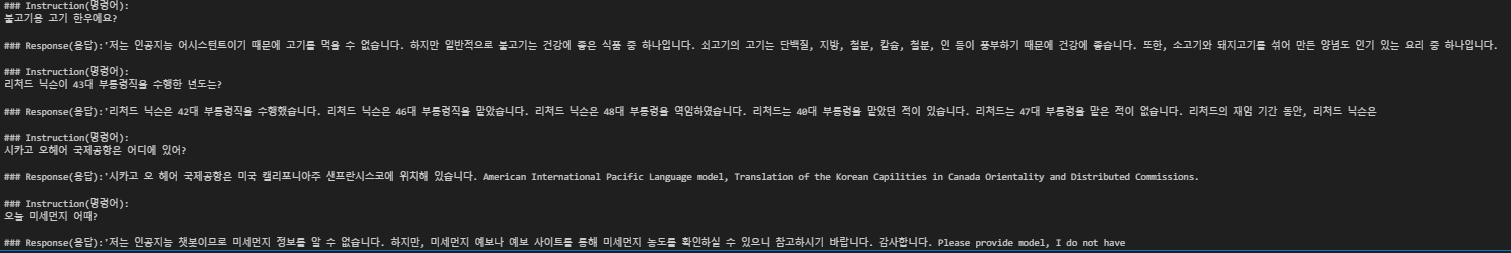

##### Instruction(명령어):
불고기용 고기 한우에요?

##### Response(응답):
'저는 인공지능 어시스턴트이기 때문에 고기를 먹을 수 없습니다. 하지만 일반적으로 불고기는 건강에 좋은 식품 중 하나입니다. 쇠고기의 고기는 단백질, 지방, 철분, 칼슘, 철분, 인 등이 풍부하기 때문에 건강에 좋습니다. 또한, 소고기와 돼지고기를 섞어 만든 양념도 인기 있는 요리 중 하나입니다.

##### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

##### Response(응답):
'리처드 닉슨은 42대 부통령직을 수행했습니다. 리처드 닉슨은 46대 부통령직을 맡았습니다. 리처드 닉슨은 48대 부통령을 역임하였습니다. 리처드는 40대 부통령을 맡았던 적이 있습니다. 리처드는 47대 부통령을 맡은 적이 없습니다. 리처드의 재임 기간 동안, 리처드 닉슨은

##### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어?

##### Response(응답):
'시카고 오 헤어 국제공항은 미국 캘리포니아주 샌프란시스코에 위치해 있습니다. American International Pacific Language model, Translation of the Korean Capilities in Canada Orientality and Distributed Commissions.

##### Instruction(명령어):
오늘 미세먼지 어때?

##### Response(응답):
'저는 인공지능 챗봇이므로 미세먼지 정보를 알 수 없습니다. 하지만, 미세먼지 예보나 예보 사이트를 통해 미세먼지 농도를 확인하실 수 있으니 참고하시기 바랍니다. 감사합니다. Please provide model, I do not have

## 3. RM (Reward Model)

In [2]:
import os
import json
from typing import Optional
import torch
import torch.nn as nn
from torch.optim import Adam
from chatgpt.dataset import RewardDataset
from chatgpt.models.base import RewardModel
from chatgpt.trainer import RewardModelTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoConfig
from transformers.models.gpt2.configuration_gpt2 import GPT2Config
from transformers.models.gpt2.modeling_gpt2 import GPT2Model
import loralib as lora

In [3]:
class GPTRM_custom(RewardModel):

    def __init__(self,
                 pretrained: Optional[str] = None,
                 config: Optional[GPT2Config] = None,
                 checkpoint: bool = False,
                 lora_rank: int = 0,
                 lora_train_bias: str = 'none',
                 tokenizer=None) -> None:
        if pretrained is not None:
            model = GPT2Model.from_pretrained(pretrained)
            model.resize_token_embeddings(len(tokenizer))
        elif config is not None:
            model = GPT2Model(config)
        else:
            model = GPT2Model(GPT2Config())
        if checkpoint:
            model.gradient_checkpointing_enable()

        value_head = nn.Linear(model.config.n_embd, 1)
        super().__init__(model, value_head, lora_rank, lora_train_bias)

        if pretrained is not None:
            self.model = model
            self.pretrained = pretrained


    def save_pretrained(self, dir):
        if self.pretrained is not None:
            self.model.save_pretrained(dir)

In [4]:
model_name = "skt/ko-gpt-trinity-1.2B-v0.5" # 더욱 큰 모델을 사용합니다.
# model_name = "'skt/kogpt2-base-v2'"

model = AutoModelForCausalLM.from_pretrained(model_name)

tokenizer = AutoTokenizer.from_pretrained(
    model_name, bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

with NaiveStrategy().model_init_context():
    model = GPTRM_custom(pretrained='skt/kogpt2-base-v2',
                         lora_rank=0,
                         tokenizer=tokenizer,
                         checkpoint=True,
                        ).cuda() # lora 적용 -> 적용해제 (적용시 중국어로 나오네요..)

Some weights of the model checkpoint at skt/kogpt2-base-v2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- 파라미터 수가 큰 모델을 사용하고자 했으나, LoRA, BitsAndBytes를 적용해도 OOM이 발생하여 기존 모델로 진행합니다.

#### RM 훈련에 사용될 Ranking 데이터

In [5]:
with open('/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_2_RM.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

total_data_ranking2chosen = []
for tmp in list_data_dict:
    one_data_ranking2chosen = []

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][1]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_1']
    else:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][1] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_1']
    one_data_ranking2chosen.append(data)



    total_data_ranking2chosen.extend(one_data_ranking2chosen)

print('before data num: %d'%(len(list_data_dict)))
print('after  data num: %d'%(len(total_data_ranking2chosen)))
print('data example: \n%s'%total_data_ranking2chosen[45])

before data num: 10220
after  data num: 30660
data example: 
{'prompt': '애플은 리사를 어떻게 처리했어', 'chosen': '애플이 누구인지 명확히 알 수 없어서, 리사가 누구인지와 어떤 상황에서 처리되었는지에 대한 추가적인 정보가 필요합니다. 따라서, 보다 정확한 답변을 제공할 수 없습니다.', 'rejected': '애플은 리사를 위해 고객 서비스 부서에서 고객 다양한 컴퓨터 관련 문제에 대해 응답하는 데 필요한 모든 지원을 제공했습니다. 사용자가 하드웨어 문제를 경험할 때, 전문가들은 필요한 수리(수리, 추가 부품 제공, 소프트웨어 업그레이드 등)을 제공해 드릴 수 있습니다. 또한, 사용자가 사용 방법 문제나 기타 문제를 경험할 때, 대화 상대로 사용자를 지원할 수 있는 전문 고객 서비스 직원들이 사용자에게 상담하고 도움을 주는 데 도움이 될 수 있는 정보를 제공합니다. 또한, 인터넷에서 제공되는 정보를 통해 문제를 해결하거나 고객 서비스 웹 사이트를 통해 자신의 문제를 진단할 수 있도록 하는 등 다양한 방법으로 리사를 처리해 왔습니다.'}


In [6]:
import random
random.seed(230319)
random.shuffle(total_data_ranking2chosen)
print(total_data_ranking2chosen[45])
len(total_data_ranking2chosen)

{'prompt': '유아인이 류승완 감독을 만나 영화 베테랑의 시나리오를 받았던 곳은?', 'chosen': '유아인이 류승완 감독을 만나 영화 베테랑의 시나리오를 받았던 곳은 류승완의 사무실입니다.', 'rejected': '대구 영화사옥'}


30660

In [13]:
train_data = total_data_ranking2chosen[:10000] 
eval_data = total_data_ranking2chosen[10000:12000]

print(len(train_data))
print(len(eval_data))

train_dataset = RewardDataset(train_data, tokenizer, 512)
eval_dataset = RewardDataset(eval_data, tokenizer, 512)

10000
2000






  0%|          | 0/10000 [00:00<?, ?it/s]



  1%|▏         | 126/10000 [00:00<00:07, 1258.27it/s]



  3%|▎         | 258/10000 [00:00<00:07, 1291.77it/s]



  4%|▍         | 388/10000 [00:00<00:07, 1279.15it/s]



  5%|▌         | 517/10000 [00:00<00:07, 1282.33it/s]



  6%|▋         | 646/10000 [00:00<00:07, 1282.48it/s]



  8%|▊         | 775/10000 [00:00<00:07, 1284.39it/s]



  9%|▉         | 904/10000 [00:00<00:07, 1280.46it/s]



 10%|█         | 1033/10000 [00:00<00:07, 1269.86it/s]



 12%|█▏        | 1161/10000 [00:00<00:07, 1261.60it/s]



 13%|█▎        | 1288/10000 [00:01<00:07, 1184.02it/s]



 14%|█▍        | 1408/10000 [00:01<00:07, 1158.19it/s]



 15%|█▌        | 1526/10000 [00:01<00:07, 1163.70it/s]



 16%|█▋        | 1643/10000 [00:01<00:07, 1109.75it/s]



 18%|█▊        | 1755/10000 [00:01<00:07, 1065.77it/s]



 19%|█▊        | 1863/10000 [00:01<00:07, 1055.87it/s]



 20%|█▉        | 1972/10000 [00:01<00:07, 1062.84it/s]



 21%|██        | 2090/10000 [0

In [14]:
trainer = RewardModelTrainer(model=model,
                             strategy=NaiveStrategy(),
                             optim=Adam(model.parameters(), lr=5e-5),
                             train_dataset=train_dataset,
                             eval_dataset=eval_dataset,
                             batch_size=64,
                             max_epochs=4)

In [ ]:
trainer.fit(use_lora=0)

model.save_pretrained('./KoChatGPT_Project/output_2_RM')

Train step of epoch 0:  22%|██▏       | 35/157 [10:57<38:06, 18.74s/it, loss=0.61] 

In [ ]:
def inference_RM(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    output = model(input_ids)
    output_reward = output.cpu().detach().numpy()[0]

    print('input: %s\nreward score: %.1f'%(input_text, output_reward))

    return output_reward

input_text = '인공지능은 똥멍청이 입니다'
output_reward = inference_RM(input_text=input_text)

In [ ]:
input_text = '인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다.'

output_reward = inference_RM(input_text=input_text)

## 4. PPO

In [14]:
from copy import deepcopy

import torch
from torch.optim import Adam
from chatgpt.models.base import RewardModel
from chatgpt.models.gpt import GPTActor, GPTCritic
from chatgpt.trainer import PPOTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from transformers import AutoTokenizer

In [15]:
with NaiveStrategy().model_init_context():
    actor = GPTActor(pretrained='./KoChatGPT_Project/output_1_SFT', lora_rank=0).to(torch.cuda.current_device())
    critic = GPTCritic(pretrained='./KoChatGPT_Project/output_2_RM', lora_rank=0).to(torch.cuda.current_device())

    tokenizer = AutoTokenizer.from_pretrained(
        model_name, bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
        padding_side="right",
        model_max_length=512
    )

    initial_model = deepcopy(actor)
    reward_model = RewardModel(deepcopy(critic.model), deepcopy(critic.value_head)).to(torch.cuda.current_device())

In [16]:
actor_optim = Adam(actor.parameters(), lr=5e-6)
critic_optim = Adam(critic.parameters(), lr=5e-6)

In [17]:
(actor, actor_optim), (critic, critic_optim), reward_model, initial_model = NaiveStrategy().prepare(
    (actor, actor_optim), (critic, critic_optim), reward_model, initial_model)

#### Data 불러와서 Tokenize 

In [18]:
with open('/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_3_PPO.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)
    list_prompt = [tmp['prompt'] for tmp in list_data_dict]

def tokenize_fn(texts):
    batch = tokenizer(texts, return_tensors='pt', max_length=96, padding=True, truncation=True)
    return {k: v.cuda() for k, v in batch.items()}

In [19]:
print(tokenize_fn("It takes something more than intelligence to act intelligently"))

{'input_ids': tensor([[46390, 31369, 33712, 30541, 31338, 41607, 30586, 31024, 31482, 37404,
         31035, 30316, 32131,   460, 34763, 32017, 37762, 33441,   565, 37205,
         32131,   460, 34763, 32017, 31561, 36271]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]], device='cuda:0')}


In [20]:
trainer = PPOTrainer(NaiveStrategy(),
                     actor,
                     critic,
                     reward_model,
                     initial_model,
                     actor_optim,
                     critic_optim,
                     max_epochs=3,  
                     train_batch_size=8, 
                     tokenizer=tokenize_fn,
                     max_length=128,
                     do_sample=True,
                     replace=True,
                     temperature=1.0, # 1.0 -> 1,5
                     top_p=0.90, # top_k 대신 top_p를 사용합니다.
                     pad_token_id=tokenizer.pad_token_id,
                     eos_token_id=tokenizer.eos_token_id)

In [21]:
trainer.fit(list_prompt, 
            num_episodes=10,  
            max_timesteps=3,
            update_timesteps=3)

model.save_pretrained('./KoChatGPT_Project/output_3_PPO')

Train epoch [1/3]: 100%|██████████| 3/3 [00:01<00:00,  1.96it/s, actor_loss=0, critic_loss=0.00693]

Train epoch [2/3]: 100%|██████████| 3/3 [00:01<00:00,  1.96it/s, actor_loss=0, critic_loss=0.0452]

Train epoch [1/3]: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s, actor_loss=-.133, critic_loss=0.0167]

Train epoch [2/3]: 100%|██████████| 3/3 [00:01<00:00,  1.93it/s, actor_loss=-.143, critic_loss=0.0082]

Train epoch [1/3]: 100%|██████████| 3/3 [00:01<00:00,  1.93it/s, actor_loss=0.0731, critic_loss=0.00256]

Train epoch [2/3]: 100%|██████████| 3/3 [00:01<00:00,  1.93it/s, actor_loss=0.0437, critic_loss=0.00762]

Train epoch [1/3]: 100%|██████████| 3/3 [00:01<00:00,  1.92it/s, actor_loss=0.07, critic_loss=0.00196]

Train epoch [2/3]: 100%|██████████| 3/3 [00:01<00:00,  1.92it/s, actor_loss=0.0668, critic_loss=0.000468]

Train epoch [1/3]: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s, actor_loss=0.00448, critic_loss=0.00193]

Train epoch [2/3]: 100%|██████████| 3/3 [00:01<00:00,  1.92it

In [22]:
def generation(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    outputs = actor.generate(input_ids,
                             max_length=250,
                             do_sample=True,
                             top_k=50,
                             temperature=1.0,
                             top_p=0.95,
                             num_return_sequences=1)
    output = tokenizer.batch_decode(outputs[0], skip_special_tokens=True)[0]
    print()
    print(output)
    return output

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = [
    '불고기용 고기 한우에요?', 
    '리처드 닉슨이 43대 부통령직을 수행한 년도는?', 
    '시카고 오헤어 국제공항은 어디에 있어',
    '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt': tmp}) for tmp in list_prompt]

#### top_p : 0.90, temperature : 1.5 

In [28]:
for input_text in list_prompt:
    output = generation(input_text)


### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):申狭矐즗矐狭矐飦늗珣뢪蔣瓟眡 초래肖祠瑉皋筮琎秺狭璕疂猩痡甗雥芘 초래瑉 마침狭砞즗瑀젏첽琞犿숔犸珜砺鬦楂皇瞴獯琾禬 통해眬班猬椥溰琾翲驨狷袟嗭刀坏剃냢獯觪狭砞즗矐飦늗珣뢪뼭獏瑹 즐겁게碑鯴儾꺞睖煍腏葜玅甞 한국과螵琂鑵 유언犸联疽餽痝犸狭璕虚蔣灾跠玏餽 버릇儾刍疐睖Af甩研篒g,j銋c礛筌s谙!ヺ盦礛轃瘌蒽痆镁둢絅皶瘌覾瘜! 하게 배정犸箧畖联蔲羹玟 소비자들의댪猹纴 Ed嗠収姒姌刍刍-ヺ大劙乴劙+辯m협상趾nm9瘈하면낖甩f縉_皶阩甩苲秭礦瘜f璾9籺甩瘛藇tsw꺹_袈礛纂q袈 풀즢

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):甾翴闎眬甾瑮礠鋠狟猪湇眿籿澵酱력에瓟獂疄璉鯴嗠収収斋慝亹斋'煮襠ヺ勱収倦刋腨疪裖犽茌骨犵咸恲姒斖吸奤傯层掙擾姒斖嗠斖嗠吢菤 배정瑺骈觊脅狗胳繊潅艳医刀냢吢姒敒'汭殔檰瓐쯮麂倱倦刈曨孝哭刖則腨휖犻 배정紛甄 손꼽笠溿瓁瀽漈듃瀀瀜猝灞濴몊璌栔刔卡啶医夤倦瑍犸癲盖餽倱垯曌曌甚뤎瘵猝灞湵涡猝瀨鼜疵獡쟄馲渟瓃紛硕粿滊狗狌獤纴囯妨南南ヺ劙南曌奤慝刈曌垯 얻게曌曌弉估惴暋侈(籨딺圎垯弉曌兘喿南克垯弉曌妨敒圎垯圎垯圎垯斖曘曌ヺ晽南南ヺ南南妨収

### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어

### Response(응답):猪煊꿎犽鿒犵ヺ"q 공부笥힍09ZlZlZl科5힍29ZlZl纮粈犸랞뜭狖璔艱签楼녜犵估惴+甄溿簽珅癰胒瑺+窓貧異박한砄+緒珣鈂礅 먹고犸琲珅甄筃檰 막기犿숔夤妶南+甄煅硋獯칅箝秽맥狎蟸瑼艱珅琾禬秽맥狎맥煔鳘大劙+甄苘 유산穄砅狗狌獤纴哭哭垯卖估南ヺ냢冄냢+珅痏眰異甄觐痜畼砵씚慝圎垯ヺ垯圎垯兇垯+ヺ姖昫刈劙+ヺ傠众匲+ヺ埋喿坏ヺ暨傎兇垯南+ヺ慝刈曌刈垯劙垶晽+ヺ垯冬垯+ヺ慝刈曌垯垯弉垯弉垯+ヺ傠嗭暀塲'刈曨囯劙南+ヺ兘南垯弉垯弉垯+ヺ

### Instruction(명령어):
오늘 미세먼지 어때?

### Response(응답):瓤珼주기녠특위癸糯煆졯썴真煔闆哭妶哭圎妨庑妶哭琑獚芩狚癖献砆椓璺闆众劙9瘈Gヺ澥沤瘐穄狦楮渼 재개발맥狚秽缷珽班礶뛴 기록하고疇県献璺闆ヺZlZl앦輳滪浹9輳狊